# A NYC Taxi data cleaning and model building pipeline to forecast the estimated trip time from A2B in NYC

In [1]:
import os as os
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import datetime as dt
plt.style.use('seaborn-whitegrid')

plt.rcParams['image.cmap'] = 'blue'

#sns.set_context('notebook',font_scale=2)
sns.set_style("whitegrid")
% matplotlib inline
labelsize = 22
mpl.rcParams.update({'font.size': labelsize})
mpl.rcParams.update({'figure.figsize': (20,10)})
mpl.rcParams.update({'axes.titlesize': 'large'})
mpl.rcParams.update({'axes.labelsize': 'large'})
mpl.rcParams.update({'xtick.labelsize': labelsize})
mpl.rcParams.update({'ytick.labelsize': labelsize})
# mpl.rcParams.keys()

In [2]:
!cd data && ls

2014-05 - Citi Bike trip data.csv
bike_20140505_with_dist_and_avg_velo.csv
bike_20140505_with_dist.csv
bike_20140505_with_dist_velo.csv
bike_oneweekfrom20140505.csv
data_jan13.csv
README.txt
Taxi_from_2013-05-06_to_2013-05-13.csv
Taxi_from_2013-05-06_to_2013-05-13_testset.csv
Taxi_from_2013-05-06_to_2013-05-13testset.csv
Taxi_from_2013-05-06_to_2013-05-13_xtrain.csv
Taxi_from_2013-05-06_to_2013-05-13_ytrain.csv
taxi_oneweekfrom20130107.csv
taxi_oneweekfrom20130506.csv
taxi_oneweekfrom20140505.csv
taxi_tree_test_X_20130506-12.csv
taxi_tree_test_X.csv
taxi_tree_test_Xy_20130506-12.csv
taxi_tree_test_Xy.csv
taxi_tree_test_Xy_sample.csv
taxi_tree_test_y_20130506-12.csv
taxi_tree_test_y.csv
_testset.csv
yellow_tripdata_2013-05.csv
yellow_tripdata_2014-05.csv


Use the bash =)

In [3]:
data = pd.read_csv('data/Taxi_from_2013-05-06_to_2013-05-13.csv', index_col=0, parse_dates=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3534632 entries, 0 to 3534631
Data columns (total 19 columns):
vendor_id             object
pickup_datetime       object
dropoff_datetime      object
passenger_count       int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
rate_code             int64
store_and_fwd_flag    object
dropoff_longitude     float64
dropoff_latitude      float64
payment_type          object
fare_amount           float64
surcharge             float64
mta_tax               float64
tip_amount            float64
tolls_amount          float64
total_amount          float64
trip_time             object
dtypes: float64(11), int64(2), object(6)
memory usage: 539.3+ MB


So parsing does not work, do it manually:

In [5]:
data['pickup_datetime'] =pd.to_datetime(data['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
data['dropoff_datetime'] =pd.to_datetime(data['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')

In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
passenger_count,3534632.0,1.708266,1.380270,0.000000,1.000000,1.000000,2.000000,6.000000
trip_distance,3534632.0,2.875593,3.343748,0.000000,1.050000,1.800000,3.200000,100.000000
pickup_longitude,3534632.0,-72.621180,10.142067,-1625.033333,-73.992272,-73.981786,-73.966735,40.867882
pickup_latitude,3534632.0,39.981485,6.522288,-3113.281477,40.734916,40.752702,40.767551,2047.454950
rate_code,3534632.0,1.032870,0.345708,0.000000,1.000000,1.000000,1.000000,210.000000
dropoff_longitude,3534618.0,-72.575137,10.450838,-2038.393545,-73.991547,-73.980110,-73.963510,2386.995232
dropoff_latitude,3534618.0,39.952355,7.665360,-3114.304505,40.733845,40.753077,40.768337,3210.392762
fare_amount,3534632.0,12.491013,10.078369,2.500000,6.500000,9.500000,14.500000,500.000000
surcharge,3534632.0,0.320163,0.362772,0.000000,0.000000,0.000000,0.500000,9.500000
mta_tax,3534632.0,0.498208,0.029876,0.000000,0.500000,0.500000,0.500000,0.500000


In [7]:
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_time
0,VTS,2013-05-06,2013-05-06 00:10:00,1,2.65,-73.981070,40.766047,1,NaN,-73.981362,40.738092,CRD,10.5,0.5,0.5,2.20,0.0,13.70,0 days 00:10:00.000000000
1,VTS,2013-05-06,2013-05-06 00:06:00,5,1.86,-73.986312,40.760487,1,NaN,-74.005082,40.743372,CSH,7.5,0.5,0.5,0.00,0.0,8.50,0 days 00:06:00.000000000
2,VTS,2013-05-06,2013-05-06 00:04:00,1,0.90,-73.989388,40.731577,1,NaN,-73.986102,40.740732,CSH,5.5,0.5,0.5,0.00,0.0,6.50,0 days 00:04:00.000000000
3,VTS,2013-05-06,2013-05-06 00:08:00,1,2.59,-73.994590,40.751857,1,NaN,-73.963470,40.765912,CSH,9.5,0.5,0.5,0.00,0.0,10.50,0 days 00:08:00.000000000
4,VTS,2013-05-06,2013-05-06 00:29:00,1,18.26,-73.783327,40.648510,1,NaN,-73.974808,40.624810,CRD,51.5,0.5,0.5,6.75,0.0,59.25,0 days 00:29:00.000000000


In [8]:
payments = data.payment_type.value_counts()

Some statistics about the payment.

In [9]:
payments/len(data)

CRD    0.537525
CSH    0.459272
NOC    0.002171
DIS    0.000694
UNK    0.000339
Name: payment_type, dtype: float64

## So thats the statistic about payments. Remember, there are to tips recorded for cash payment

How many trips are affected by tolls?

In [10]:
data.tolls_amount.value_counts()/len(data)

0.00     9.535745e-01
5.33     4.322657e-02
10.25    1.000670e-03
2.44     4.175824e-04
8.25     3.850472e-04
10.66    2.648083e-04
4.80     9.760563e-05
7.50     8.345989e-05
15.58    7.016289e-05
15.99    6.591917e-05
15.00    3.904225e-05
15.25    3.762768e-05
13.25    3.564728e-05
14.25    3.281813e-05
12.25    3.196938e-05
13.00    2.998898e-05
2.00     2.319902e-05
13.58    2.291611e-05
12.00    2.291611e-05
14.00    1.867238e-05
5.00     1.782364e-05
16.25    1.612615e-05
12.75    1.527740e-05
5.30     1.471157e-05
16.00    1.357991e-05
14.75    1.273117e-05
17.00    1.159951e-05
14.55    1.103368e-05
12.40    1.046785e-05
16.50    1.018494e-05
             ...     
8.24     2.829149e-07
5.74     2.829149e-07
17.99    2.829149e-07
12.58    2.829149e-07
16.16    2.829149e-07
5.31     2.829149e-07
0.06     2.829149e-07
13.06    2.829149e-07
12.97    2.829149e-07
6.80     2.829149e-07
4.30     2.829149e-07
4.55     2.829149e-07
12.22    2.829149e-07
17.80    2.829149e-07
13.80    2

So 95% of the drives do not deal with tolls. We will drop the column then.

We are not interested in the following features (they do not add any further information):

In [11]:
data = data.drop(['vendor_id', 'rate_code', 'store_and_fwd_flag','payment_type','mta_tax', 'tolls_amount',
               'surcharge'], axis=1)

In [12]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
passenger_count,3534632.0,1.708266,1.380270,0.000000,1.000000,1.000000,2.000000,6.000000
trip_distance,3534632.0,2.875593,3.343748,0.000000,1.050000,1.800000,3.200000,100.000000
pickup_longitude,3534632.0,-72.621180,10.142067,-1625.033333,-73.992272,-73.981786,-73.966735,40.867882
pickup_latitude,3534632.0,39.981485,6.522288,-3113.281477,40.734916,40.752702,40.767551,2047.454950
dropoff_longitude,3534618.0,-72.575137,10.450838,-2038.393545,-73.991547,-73.980110,-73.963510,2386.995232
dropoff_latitude,3534618.0,39.952355,7.665360,-3114.304505,40.733845,40.753077,40.768337,3210.392762
fare_amount,3534632.0,12.491013,10.078369,2.500000,6.500000,9.500000,14.500000,500.000000
tip_amount,3534632.0,1.366541,2.157769,0.000000,0.000000,1.000000,2.000000,155.500000
total_amount,3534632.0,14.936348,12.109785,2.500000,8.000000,11.300000,16.750000,500.000000


# First, we want to generate the trip_time because this is our target.

In [13]:
data['trip_time']=data.dropoff_datetime-data.pickup_datetime
data.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time
0,2013-05-06,2013-05-06 00:10:00,1,2.65,-73.981070,40.766047,-73.981362,40.738092,10.5,2.20,13.70,00:10:00
1,2013-05-06,2013-05-06 00:06:00,5,1.86,-73.986312,40.760487,-74.005082,40.743372,7.5,0.00,8.50,00:06:00
2,2013-05-06,2013-05-06 00:04:00,1,0.90,-73.989388,40.731577,-73.986102,40.740732,5.5,0.00,6.50,00:04:00
3,2013-05-06,2013-05-06 00:08:00,1,2.59,-73.994590,40.751857,-73.963470,40.765912,9.5,0.00,10.50,00:08:00
4,2013-05-06,2013-05-06 00:29:00,1,18.26,-73.783327,40.648510,-73.974808,40.624810,51.5,6.75,59.25,00:29:00


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3534632 entries, 0 to 3534631
Data columns (total 12 columns):
pickup_datetime      datetime64[ns]
dropoff_datetime     datetime64[ns]
passenger_count      int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
fare_amount          float64
tip_amount           float64
total_amount         float64
trip_time            timedelta64[ns]
dtypes: datetime64[ns](2), float64(8), int64(1), timedelta64[ns](1)
memory usage: 350.6 MB


# Check for missing and false data:

In [15]:
data.isnull().sum()

pickup_datetime       0
dropoff_datetime      0
passenger_count       0
trip_distance         0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
fare_amount           0
tip_amount            0
total_amount          0
trip_time             0
dtype: int64

So there is not that much data missing. That's quite surprising, maybe it's wrong.

In [16]:
(data==0).sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count           31
trip_distance          39596
pickup_longitude       61811
pickup_latitude        61403
dropoff_longitude      63932
dropoff_latitude       63565
fare_amount                0
tip_amount           1690455
total_amount               0
trip_time              10653
dtype: int64

So we have many zeros in the data. How much percent?

In [17]:
(data==0).sum()/len(data)

pickup_datetime      0.000000
dropoff_datetime     0.000000
passenger_count      0.000009
trip_distance        0.011202
pickup_longitude     0.017487
pickup_latitude      0.017372
dropoff_longitude    0.018087
dropoff_latitude     0.017983
fare_amount          0.000000
tip_amount           0.478255
total_amount         0.000000
trip_time            0.003014
dtype: float64

# <font color = 'blue' > Most of the zeros are missing data. So flag them as NaN (means also NA) to be consistent! </font color>

In [18]:
data = data.replace(np.float64(0), np.nan);

In [19]:
data.isnull().sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count           31
trip_distance          39596
pickup_longitude       61811
pickup_latitude        61403
dropoff_longitude      63946
dropoff_latitude       63579
fare_amount                0
tip_amount           1690455
total_amount               0
trip_time              10653
dtype: int64

Quick preview about the trip_times

## A quick look at the trip time before preprocessing

0.025     2.000000
0.500    10.516667
0.750    16.833333
0.950    31.000000
0.975    38.400000
0.990    49.850000
Name: trip_time, dtype: float64


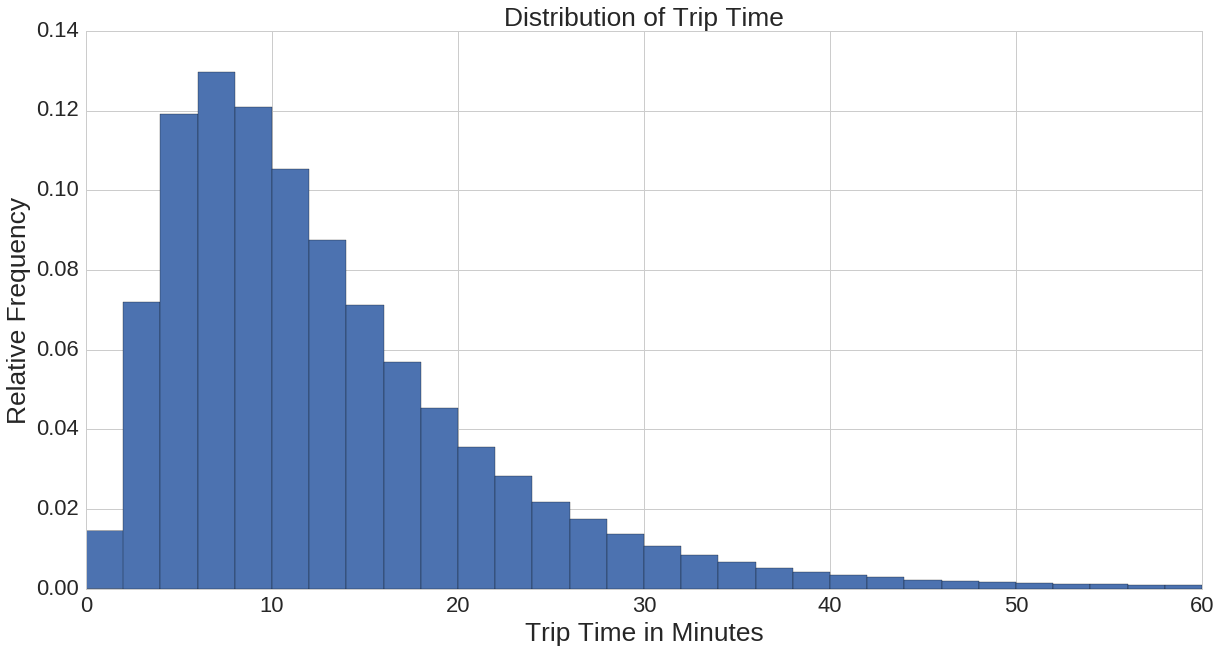

In [20]:
trip_times_in_minutes = data['trip_time'] / np.timedelta64(1, 'm')
plt.hist(trip_times_in_minutes , bins=30, range=[0, 60], 
         weights=np.zeros_like(trip_times_in_minutes) + 1. / trip_times_in_minutes.size)
#plt.yscale('log')
print(trip_times_in_minutes.quantile(q=[0.025, 0.5, 0.75, 0.95, 0.975, 0.99]))
plt.xlabel('Trip Time in Minutes')
plt.ylabel('Relative Frequency')
plt.title('Distribution of Trip Time')
plt.savefig('figures/trip_time_distribution.eps', format='eps', dpi=1000)

In [21]:
len(data.trip_time.value_counts().values)

5840

That many unique values do we have in trip_time.

Identify the the cases without geo data and remove them from our data to be processed.

In [22]:
anomaly = data.loc[(data['dropoff_longitude'].isnull()) | (data['dropoff_latitude'].isnull()) | 
                       (data['pickup_longitude'].isnull()) | (data['pickup_latitude'].isnull())]
data = data.drop(anomaly.index)

In [23]:
anomaly['flag'] = 'geo_NA'

In [24]:
data.isnull().sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count           12
trip_distance          32873
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
fare_amount                0
tip_amount           1656902
total_amount               0
trip_time               3864
dtype: int64

So how many percent of data are left to be processed?

In [25]:
len(data)/(len(data)+len(anomaly))

0.981279805082962

In [26]:
anomaly.tail()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time,flag
3534421,2013-05-12 23:58:56,2013-05-13 00:05:43,1.0,2.0,NaN,NaN,NaN,NaN,8.0,1.8,10.8,00:06:47,geo_NA
3534518,2013-05-12 23:59:02,2013-05-13 00:16:03,3.0,6.1,NaN,NaN,NaN,NaN,15.0,NaN,16.0,00:17:01,geo_NA
3534615,2013-05-12 23:59:52,2013-05-13 00:23:15,1.0,5.4,NaN,NaN,NaN,NaN,20.5,NaN,21.5,00:23:23,geo_NA
3534618,2013-05-12 23:59:54,2013-05-13 00:07:45,1.0,1.8,NaN,NaN,NaN,NaN,8.0,NaN,9.0,00:07:51,geo_NA
3534623,2013-05-12 23:59:56,2013-05-13 00:14:28,1.0,7.6,NaN,NaN,NaN,NaN,23.0,NaN,24.0,00:14:32,geo_NA


## <font color = 'black'> So we only dropped 2% of the data because of missing geo tags. Someone could search the 'anomaly'-data for patterns, e.g. for fraud detection. We are also going to drop all the unrecognized trip_distances because we cannot (exactly) generate them (an approximation would be possible). </font color>

In [27]:
anomaly = anomaly.append(data.loc[(data['trip_distance'].isnull())])
anomaly.loc[data.loc[(data['trip_distance'].isnull())].index,'flag'] = 'trip_dist_NA'
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,flag,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time
3534334,2013-05-13 00:03:12,40.749736,-73.978713,5.5,trip_dist_NA,1.0,2013-05-12 23:58:16,40.754459,-73.964803,NaN,6.5,NaN,00:04:56
3534517,2013-05-13 00:13:53,40.690212,-73.978735,14.0,trip_dist_NA,1.0,2013-05-12 23:59:01,40.733297,-73.987381,NaN,15.0,NaN,00:14:52
3534607,2013-05-13 00:05:02,40.744680,-73.999020,6.0,trip_dist_NA,1.0,2013-05-12 23:59:50,40.733435,-74.002994,NaN,7.0,NaN,00:05:12
3534612,2013-05-13 00:09:30,40.706187,-74.013075,9.5,trip_dist_NA,1.0,2013-05-12 23:59:52,40.729327,-73.992207,NaN,10.5,NaN,00:09:38
3534626,2013-05-13 00:00:28,40.757354,-73.967262,58.0,trip_dist_NA,1.0,2013-05-12 23:59:58,40.757354,-73.967262,11.6,69.6,NaN,00:00:30


In [28]:
data = data.drop(anomaly.index, errors='ignore') # ignore uncontained labels

In [29]:
data.isnull().sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count            9
trip_distance              0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
fare_amount                0
tip_amount           1638285
total_amount               0
trip_time               2922
dtype: int64

In [30]:
1-len(data)/(len(data)+len(anomaly))

0.028020455877726502

## Drop all the columns with trip_time.isnull() 

In [31]:
anomaly = anomaly.append(data.loc[(data['trip_time'].isnull())])
anomaly.loc[data.loc[(data['trip_time'].isnull())].index,'flag'] = 'trip_time_NA'
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,flag,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time
3525186,2013-05-12 23:22:39,40.763210,-73.962524,7.0,trip_time_NA,1.0,2013-05-12 23:22:39,40.759930,-73.975325,NaN,8.0,1.30,NaT
3529613,2013-05-12 23:38:46,40.734109,-73.983598,5.0,trip_time_NA,1.0,2013-05-12 23:38:46,40.742107,-73.974624,1.2,7.2,1.00,NaT
3530873,2013-05-12 23:43:59,40.643328,-73.950397,34.0,trip_time_NA,1.0,2013-05-12 23:43:59,40.727880,-74.001728,NaN,35.0,9.90,NaT
3531118,2013-05-12 23:45:00,40.755222,-73.928660,3.0,trip_time_NA,1.0,2013-05-12 23:45:00,40.753865,-73.929723,NaN,4.0,0.15,NaT
3531331,2013-05-12 23:45:56,40.773872,-73.948701,5.5,trip_time_NA,1.0,2013-05-12 23:45:56,40.766625,-73.962938,NaN,6.5,1.20,NaT


In [32]:
data = data.drop(anomaly.index, errors='ignore') # ignore uncontained labels

# This is quite unreasonable. We have dropoff_datetime = pickup_datetime and the geo-coords of pickup and dropoff do not match! trip_time equals NaT here.

In [33]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
passenger_count,3.43266e+06,1.71448,1.38599,1,1,1,2,6
trip_distance,3.43267e+06,2.91113,3.34836,0.01,1.09,1.8,3.21,100
pickup_longitude,3.43267e+06,-73.9154,2.68755,-736.5,-73.9925,-73.9821,-73.968,40.8679
pickup_latitude,3.43267e+06,40.6919,2.91217,-74.0378,40.7365,40.7534,40.7679,2047.45
dropoff_longitude,3.43267e+06,-73.913,2.98107,-740.173,-73.9918,-73.9806,-73.9651,2387
dropoff_latitude,3.43267e+06,40.6899,3.43265,-3084.28,40.7353,40.7538,40.7686,473.982
fare_amount,3.43267e+06,12.4022,9.71666,2.5,6.5,9.5,14.5,382.75
tip_amount,1.79648e+06,2.59194,2.29176,0.01,1.3,2,3,155.5
total_amount,3.43267e+06,14.834,11.7278,2.5,8,11.3,16.7,382.76
trip_time,3432668,0 days 00:13:02.243506,0 days 00:27:26.535018,0 days 00:00:01,0 days 00:06:24,0 days 00:10:34,0 days 00:16:50,11 days 00:45:28


## After filtering regarding the trip_time

(array([  4.14860000e+04,   2.47244000e+05,   4.11413000e+05,
          4.47479000e+05,   4.18108000e+05,   3.64416000e+05,
          3.02291000e+05,   2.45960000e+05,   1.96811000e+05,
          1.57134000e+05,   1.23172000e+05,   9.75690000e+04,
          7.55190000e+04,   5.99140000e+04,   4.69780000e+04,
          3.66970000e+04,   2.90370000e+04,   2.32160000e+04,
          1.81990000e+04,   1.47690000e+04,   1.18490000e+04,
          9.75400000e+03,   7.90100000e+03,   6.83100000e+03,
          5.64600000e+03,   4.78400000e+03,   4.11200000e+03,
          3.75100000e+03,   3.13700000e+03,   2.76200000e+03,
          2.28500000e+03,   1.89500000e+03,   1.59500000e+03,
          1.43000000e+03,   1.15200000e+03,   1.03000000e+03,
          8.11000000e+02,   7.01000000e+02,   5.63000000e+02,
          4.33000000e+02,   3.88000000e+02,   3.50000000e+02,
          2.88000000e+02,   2.23000000e+02,   2.36000000e+02,
          1.84000000e+02,   1.59000000e+02,   1.33000000e+02,
        

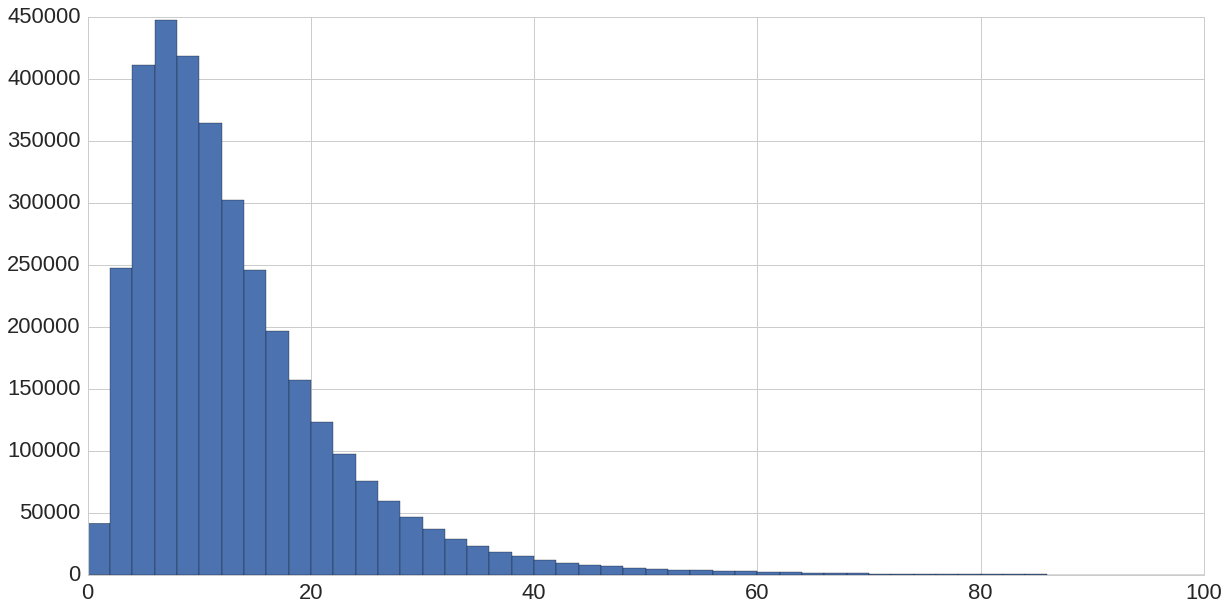

In [34]:
plt.hist(data.trip_time.values / np.timedelta64(1, 'm'), bins=50, range=[0,100])

In [35]:
print(data.trip_time.describe())
np.percentile(data.trip_time, [1,5,10,15,25,50,75,85,95,99]) / np.timedelta64(1,'m')

count                   3432668
mean     0 days 00:13:02.243506
std      0 days 00:27:26.535018
min             0 days 00:00:01
25%             0 days 00:06:24
50%             0 days 00:10:34
75%             0 days 00:16:50
max            11 days 00:45:28
Name: trip_time, dtype: object


array([  1.7945    ,   3.        ,   4.        ,   5.        ,
         6.4       ,  10.56666667,  16.83333333,  21.        ,
        31.        ,  49.08883333])

## We sometimes have some unreasonably small trip_times.

In [36]:
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,flag,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time
3525186,2013-05-12 23:22:39,40.763210,-73.962524,7.0,trip_time_NA,1.0,2013-05-12 23:22:39,40.759930,-73.975325,NaN,8.0,1.30,NaT
3529613,2013-05-12 23:38:46,40.734109,-73.983598,5.0,trip_time_NA,1.0,2013-05-12 23:38:46,40.742107,-73.974624,1.2,7.2,1.00,NaT
3530873,2013-05-12 23:43:59,40.643328,-73.950397,34.0,trip_time_NA,1.0,2013-05-12 23:43:59,40.727880,-74.001728,NaN,35.0,9.90,NaT
3531118,2013-05-12 23:45:00,40.755222,-73.928660,3.0,trip_time_NA,1.0,2013-05-12 23:45:00,40.753865,-73.929723,NaN,4.0,0.15,NaT
3531331,2013-05-12 23:45:56,40.773872,-73.948701,5.5,trip_time_NA,1.0,2013-05-12 23:45:56,40.766625,-73.962938,NaN,6.5,1.20,NaT


In [37]:
1-len(data)/(len(data)+len(anomaly))

0.028847133166903904

## <font color = 'blue'> So all in all, we dropped less than 3% of the data. </font color>

In [38]:
data.isnull().sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count            9
trip_distance              0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
fare_amount                0
tip_amount           1636185
total_amount               0
trip_time                  0
dtype: int64

## We can deal with that. External investigation of the anomaly is recommended.

# Start validating the non-anomaly data: Valid trip_time, valid distance?

Correct the avg amount for the initial charge. 

In [39]:
data['avg_amount_per_minute'] = (data.fare_amount-2.5) / (data.trip_time / np.timedelta64(1,'m'))

In [40]:
data.avg_amount_per_minute.describe()

count    3.432668e+06
mean     7.865239e-01
std      6.410160e+00
min      0.000000e+00
25%      5.769231e-01
50%      6.629834e-01
75%      7.857143e-01
max      6.450000e+03
Name: avg_amount_per_minute, dtype: float64

Distribution of the avg_amount_per_minute

Min:0.0
Max:6450.0


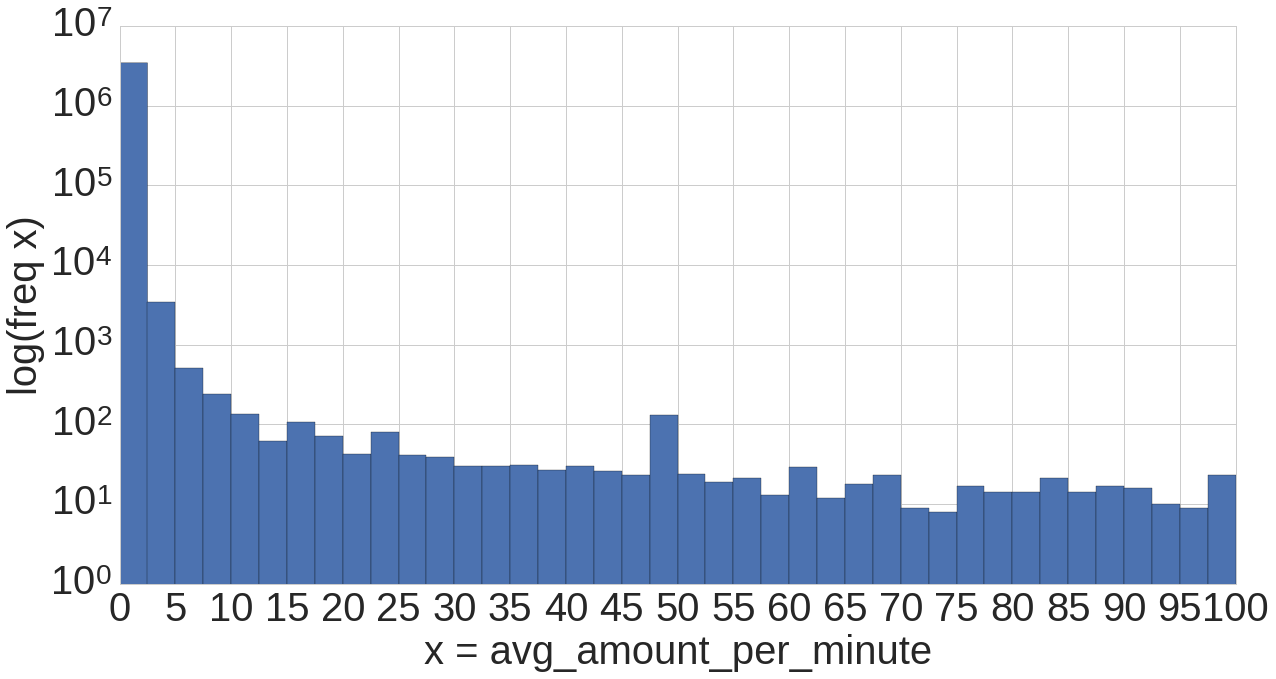

In [41]:
h = data.avg_amount_per_minute
plt.figure(figsize=(20,10))
plt.hist(h, normed=False, stacked=True, bins=40, range=[0 , 100], )
    #, histtype='stepfilled')
plt.yscale('log')
plt.ylabel('log(freq x)', fontsize=40)
plt.xlabel('x = avg_amount_per_minute', fontsize=40)
print('Min:' +  str(min(h)) + '\nMax:' +  str(max(h)))
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.locator_params(axis = 'x', nbins = 20)
plt.show()

In [42]:
data.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time,avg_amount_per_minute
0,2013-05-06,2013-05-06 00:10:00,1.0,2.65,-73.981070,40.766047,-73.981362,40.738092,10.5,2.20,13.70,00:10:00,0.800000
1,2013-05-06,2013-05-06 00:06:00,5.0,1.86,-73.986312,40.760487,-74.005082,40.743372,7.5,NaN,8.50,00:06:00,0.833333
2,2013-05-06,2013-05-06 00:04:00,1.0,0.90,-73.989388,40.731577,-73.986102,40.740732,5.5,NaN,6.50,00:04:00,0.750000
3,2013-05-06,2013-05-06 00:08:00,1.0,2.59,-73.994590,40.751857,-73.963470,40.765912,9.5,NaN,10.50,00:08:00,0.875000
4,2013-05-06,2013-05-06 00:29:00,1.0,18.26,-73.783327,40.648510,-73.974808,40.624810,51.5,6.75,59.25,00:29:00,1.689655


In [43]:
data.avg_amount_per_minute.quantile([.0001,.01, .5, .75, .95, .975, .99, .995])

0.0001    0.000000
0.0100    0.437318
0.5000    0.662983
0.7500    0.785714
0.9500    1.151163
0.9750    1.344677
0.9900    1.605263
0.9950    1.847222
Name: avg_amount_per_minute, dtype: float64

## Compare to http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml . We have a strict lower bound with .5 \$ per minute (taxi waiting in congestion). 2.5 \$ per minute match roughly     1 mile / minute (no static fares included!). So the taxi would drive 60 mp/h.  We take this as an upper bound.

In [44]:
lb = 0.5 
ub = 2.5
anomaly = anomaly.append(data.loc[(data['avg_amount_per_minute'] > ub) | 
                                  (data['avg_amount_per_minute'] < lb)])

anomaly.loc[data.loc[(data['avg_amount_per_minute'] > ub)].index,'flag'] = 'too fast'
anomaly.loc[data.loc[(data['avg_amount_per_minute'] < lb)].index,'flag'] = 'too slow'
data = data.drop(anomaly.index, errors='ignore') # ignore uncontained labels / indices
print(1-len(data)/(len(data)+len(anomaly)))

0.06037092404527544


So we dropped around 6% of the data.

In [45]:
data.avg_amount_per_minute.describe()

count    3.321243e+06
mean     7.244103e-01
std      2.173654e-01
min      5.000000e-01
25%      5.833333e-01
50%      6.666667e-01
75%      7.916667e-01
max      2.500000e+00
Name: avg_amount_per_minute, dtype: float64

In [46]:
anomaly.tail()

,avg_amount_per_minute,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,flag,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time
3534347,3.571429,2013-05-13 00:17:15,40.721621,-74.033262,70.0,too fast,1.0,2013-05-12 23:58:21,40.725023,-74.007006,2.00,80.25,3.40,00:18:54
3534376,297.000000,2013-05-12 23:58:46,40.761277,-73.993425,52.0,too fast,1.0,2013-05-12 23:58:36,40.761278,-73.993303,11.55,69.38,0.90,00:00:10
3534378,0.410959,2013-05-13 00:07:08,40.724592,-73.981777,6.0,too slow,1.0,2013-05-12 23:58:37,40.735385,-73.991185,1.40,8.40,1.10,00:08:31
3534514,2.605263,2013-05-13 00:18:00,40.792230,-73.946103,52.0,too fast,1.0,2013-05-12 23:59:00,40.666372,-73.793397,10.40,68.23,16.11,00:19:00
3534548,9.110429,2013-05-13 00:04:42,40.755859,-73.972549,52.0,too fast,1.0,2013-05-12 23:59:16,40.740766,-73.944841,11.56,69.39,2.50,00:05:26


# Only look at trips in a given bounding box


In [47]:
jfk_geodata = (40.641547, -73.778118)
ridgefield_geodata = (40.856406, -74.020642)
data_in_box = data.loc[(data['dropoff_latitude'] > jfk_geodata[0]) & 
                       (data['dropoff_longitude'] < jfk_geodata[1]) &
                       (data['dropoff_latitude'] < ridgefield_geodata[0]) & 
                       (data['dropoff_longitude'] > ridgefield_geodata[1]) & 
                       (data['pickup_latitude'] > jfk_geodata[0]) & 
                       (data['pickup_longitude'] < jfk_geodata[1]) &
                       (data['pickup_latitude'] < ridgefield_geodata[0]) & 
                       (data['pickup_longitude'] > ridgefield_geodata[1])         
                       ]
# taxidata = taxidata.drop(anomaly.index)

In [48]:
data_in_box.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time,avg_amount_per_minute
0,2013-05-06,2013-05-06 00:10:00,1.0,2.65,-73.981070,40.766047,-73.981362,40.738092,10.5,2.2,13.7,00:10:00,0.800000
1,2013-05-06,2013-05-06 00:06:00,5.0,1.86,-73.986312,40.760487,-74.005082,40.743372,7.5,NaN,8.5,00:06:00,0.833333
2,2013-05-06,2013-05-06 00:04:00,1.0,0.90,-73.989388,40.731577,-73.986102,40.740732,5.5,NaN,6.5,00:04:00,0.750000
3,2013-05-06,2013-05-06 00:08:00,1.0,2.59,-73.994590,40.751857,-73.963470,40.765912,9.5,NaN,10.5,00:08:00,0.875000
5,2013-05-06,2013-05-06 00:14:00,3.0,4.86,-73.965532,40.717052,-73.972442,40.743247,16.5,NaN,17.5,00:14:00,1.000000


In [49]:
print(jfk_geodata < ridgefield_geodata,
len(data_in_box)/len(data))

True 0.9834670332763968


So we've omitted about 2% of the data because the trips do not start and end in the box

## Inspect Manhattan only.

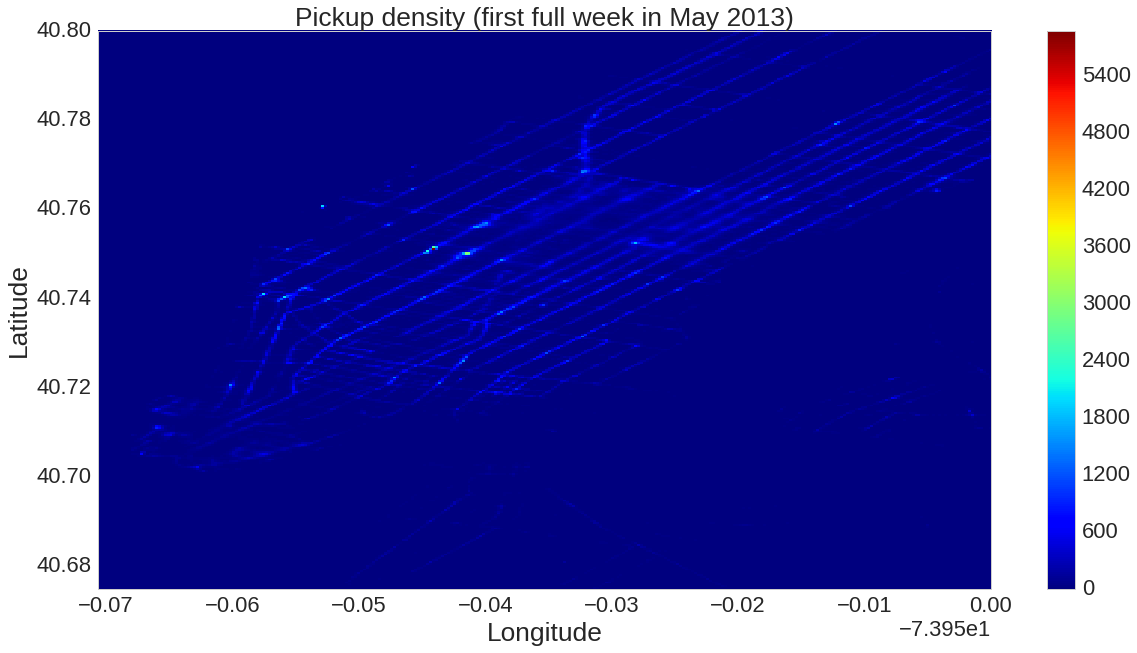

In [50]:
x = data_in_box.pickup_longitude
y = data_in_box.pickup_latitude

plt.jet()
H, xedges, yedges = np.histogram2d(x, y, bins=300)#, normed=False, weights=None)

fig = plt.figure(figsize=(20, 10))
plt.hist2d(x, y, bins=300, range=[[min(x.values),-73.95],[40.675,40.8]])
plt.colorbar()
plt.title('Pickup density (first full week in May 2013)')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

ax = fig.gca()
ax.grid(False)
# plt.savefig('figures/pickup_density_manhattan_13.png', format='png', dpi=150)

## Again, let's take a look at the distribution of the target variable we want to estimate:

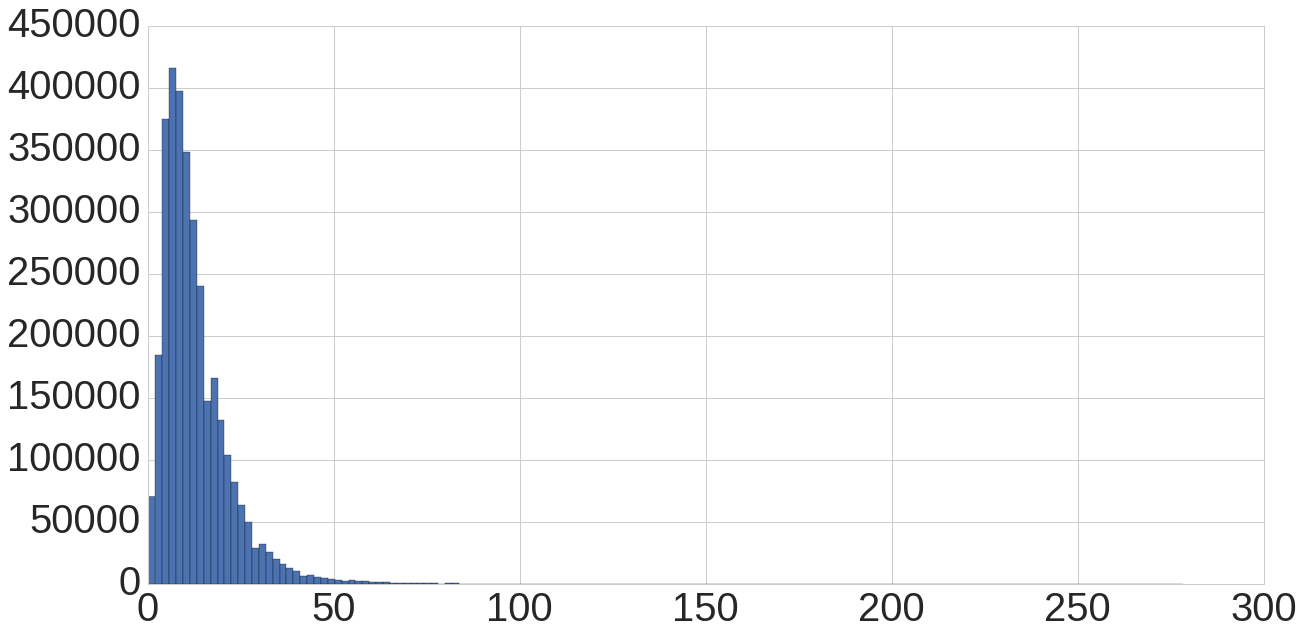

In [51]:
h = data_in_box.trip_time.values / np.timedelta64(1, 'm')
plt.hist(h, normed=False,  bins=150)
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.show()

In [52]:
data_in_box.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time,avg_amount_per_minute
0,2013-05-06,2013-05-06 00:10:00,1.0,2.65,-73.981070,40.766047,-73.981362,40.738092,10.5,2.2,13.7,00:10:00,0.800000
1,2013-05-06,2013-05-06 00:06:00,5.0,1.86,-73.986312,40.760487,-74.005082,40.743372,7.5,NaN,8.5,00:06:00,0.833333
2,2013-05-06,2013-05-06 00:04:00,1.0,0.90,-73.989388,40.731577,-73.986102,40.740732,5.5,NaN,6.5,00:04:00,0.750000
3,2013-05-06,2013-05-06 00:08:00,1.0,2.59,-73.994590,40.751857,-73.963470,40.765912,9.5,NaN,10.5,00:08:00,0.875000
5,2013-05-06,2013-05-06 00:14:00,3.0,4.86,-73.965532,40.717052,-73.972442,40.743247,16.5,NaN,17.5,00:14:00,1.000000


#  Make a new dataframe with features and targets to train the model 

In [53]:
time_regression_df = pd.DataFrame([#data_in_box['pickup_datetime'].dt.day,
                          data_in_box['pickup_datetime'].dt.dayofweek,
                          data_in_box['pickup_datetime'].dt.hour,
                          data_in_box['pickup_latitude'],
                          data_in_box['pickup_longitude'],
                          data_in_box['dropoff_latitude'],
                          data_in_box['dropoff_longitude'],
                          np.ceil(data_in_box['trip_time']/np.timedelta64(1, 'm')),
                         ]).T

In [54]:
time_regression_df.columns = ['pickup_datetime_dayofweek', 'pickup_datetime_hour',
                              'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
                              'trip_time']

Use minutes for prediction instead of seconds (ceil the time). Definitley more robust than seconds!

In [55]:
time_regression_df.tail()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time
3534627,6.0,23.0,40.744021,-73.999512,40.825470,-73.953479,15.0
3534628,6.0,23.0,40.741475,-73.981322,40.751637,-73.975838,3.0
3534629,6.0,23.0,40.770077,-73.863887,40.644504,-73.963537,22.0
3534630,6.0,23.0,40.736240,-73.990593,40.744194,-73.985401,5.0
3534631,6.0,23.0,40.772929,-73.949516,40.728967,-73.988787,15.0


In [56]:
time_regression_df.head()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time
0,0.0,0.0,40.766047,-73.981070,40.738092,-73.981362,10.0
1,0.0,0.0,40.760487,-73.986312,40.743372,-74.005082,6.0
2,0.0,0.0,40.731577,-73.989388,40.740732,-73.986102,4.0
3,0.0,0.0,40.751857,-73.994590,40.765912,-73.963470,8.0
5,0.0,0.0,40.717052,-73.965532,40.743247,-73.972442,14.0


In [57]:
time_regression_df.ix[:,0:6].describe()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,3.266333e+06,3.266333e+06,3.266333e+06,3.266333e+06,3.266333e+06,3.266333e+06
mean,3.039328e+00,1.350386e+01,4.075136e+01,-7.397645e+01,4.075162e+01,-7.397513e+01
std,1.961083e+00,6.552920e+00,2.582007e-02,3.135320e-02,2.840570e-02,3.012289e-02
min,0.000000e+00,0.000000e+00,4.064155e+01,-7.402063e+01,4.064155e+01,-7.402057e+01
25%,1.000000e+00,9.000000e+00,4.073668e+01,-7.399259e+01,4.073577e+01,-7.399176e+01
50%,3.000000e+00,1.400000e+01,4.075343e+01,-7.398216e+01,4.075387e+01,-7.398066e+01
75%,5.000000e+00,1.900000e+01,4.076813e+01,-7.396825e+01,4.076884e+01,-7.396539e+01
max,6.000000e+00,2.300000e+01,4.085636e+01,-7.377812e+01,4.085640e+01,-7.377812e+01


In [58]:
print(time_regression_df.trip_time.value_counts())
print(len(time_regression_df.trip_time.value_counts()))

7.0      216659
6.0      212922
8.0      212253
9.0      203203
5.0      198847
10.0     190577
11.0     176963
4.0      167658
12.0     161870
13.0     146481
14.0     132243
15.0     118781
3.0      115848
16.0     106682
17.0      94945
18.0      84644
19.0      75749
20.0      67035
21.0      58914
2.0       55534
22.0      52250
23.0      46464
24.0      40736
25.0      35394
26.0      31199
27.0      27649
28.0      24524
29.0      21292
30.0      18618
31.0      16680
          ...  
120.0         3
123.0         2
143.0         2
145.0         2
128.0         2
138.0         2
121.0         2
119.0         2
118.0         2
157.0         1
156.0         1
154.0         1
153.0         1
148.0         1
160.0         1
164.0         1
137.0         1
178.0         1
136.0         1
134.0         1
133.0         1
132.0         1
131.0         1
130.0         1
129.0         1
125.0         1
124.0         1
117.0         1
115.0         1
279.0         1
Name: trip_time, dtype: 

## So we hace 148 different times to predict.

In [59]:
time_regression_df.trip_time.quantile([0.05, 0.95])

0.05     3.0
0.95    30.0
Name: trip_time, dtype: float64

So 90% of the trip_times are between 3 and 30 minutes.

## A few stats about the avg. pickups per hour

In [60]:
hour_stats = time_regression_df.groupby(time_regression_df.pickup_datetime_hour)

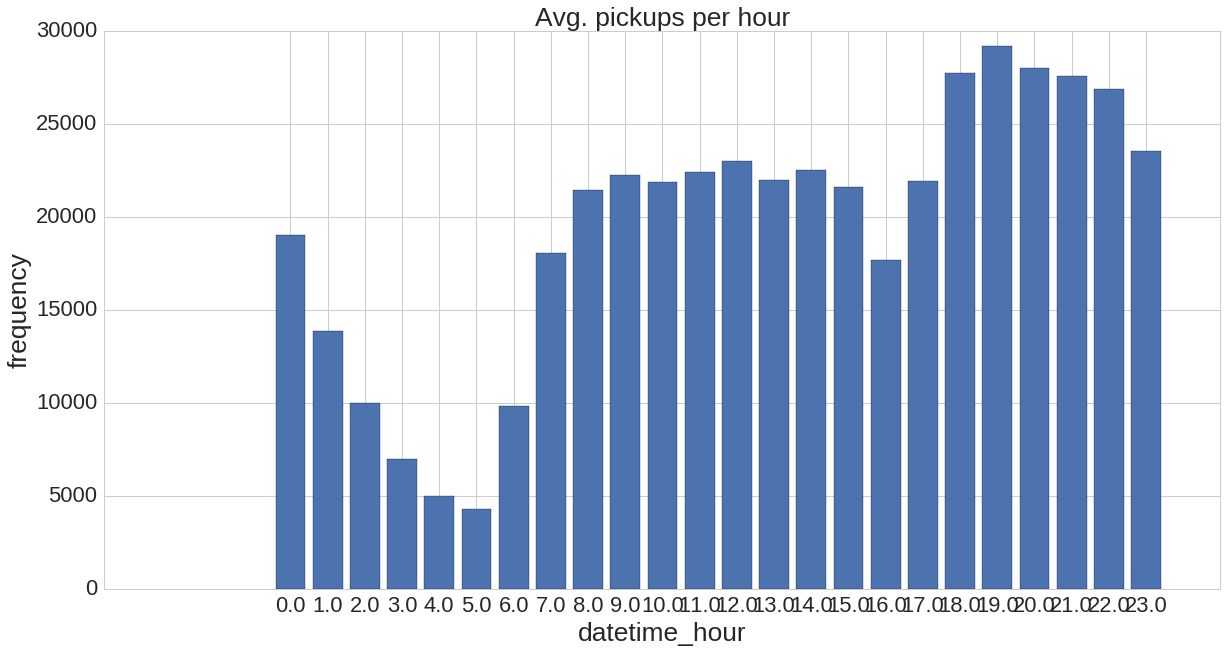

In [61]:
plt.bar(left = hour_stats.pickup_datetime_hour.count().keys(), height=hour_stats.pickup_datetime_hour.count().values/7, 
       tick_label=hour_stats.pickup_datetime_hour.count().keys(), align='center')
plt.title('Avg. pickups per hour')
plt.xlabel('datetime_hour')
plt.ylabel('frequency')
plt.savefig('avg_pickups_per_hour.png')

In [62]:
print('Avg. pickups per half-hour (summarized over 1 week)')
hour_stats.pickup_datetime_hour.count()/14

Avg. pickups per half-hour (summarized over 1 week)


pickup_datetime_hour
0.0      9498.000000
1.0      6936.000000
2.0      4986.357143
3.0      3496.357143
4.0      2482.285714
5.0      2151.500000
6.0      4909.357143
7.0      9031.214286
8.0     10726.285714
9.0     11130.571429
10.0    10944.857143
11.0    11205.857143
12.0    11487.642857
13.0    10997.642857
14.0    11269.785714
15.0    10798.785714
16.0     8841.285714
17.0    10963.857143
18.0    13860.857143
19.0    14584.714286
20.0    14010.142857
21.0    13788.142857
22.0    13446.642857
23.0    11761.357143
Name: pickup_datetime_hour, dtype: float64

In [63]:
(hour_stats.count()/14).quantile([.5])

,pickup_datetime_dayofweek,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time
0.5,10954.357143,10954.357143,10954.357143,10954.357143,10954.357143,10954.357143


# Split the data into a training dataset and a test dataset. Evaluate the performance of the decision tree on the test data

In [64]:
time_regression_df.columns

Index(['pickup_datetime_dayofweek', 'pickup_datetime_hour', 'pickup_latitude',
       'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
       'trip_time'],
      dtype='object')

In [65]:
from sklearn import cross_validation as cv
time_regression_df_train, time_regression_df_test = cv.train_test_split(time_regression_df, test_size=0.1, random_state=99)
y_train = time_regression_df_train['trip_time']
x_train = time_regression_df_train.ix[:, 0:6]
y_test = time_regression_df_test['trip_time']
x_test = time_regression_df_test.ix[:, 0:6]

In [66]:
time_regression_df_train.tail()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time
2022607,4.0,1.0,40.669259,-73.986446,40.658110,-73.996890,4.0
912919,1.0,22.0,40.784262,-73.977685,40.852637,-73.932985,17.0
3090961,6.0,0.0,40.728087,-73.988042,40.690582,-73.966325,17.0
1400751,2.0,21.0,40.769983,-73.863293,40.815013,-73.944113,15.0
1889034,3.0,20.0,40.760670,-73.969077,40.716767,-74.004000,17.0


In [67]:
len(x_train)

2939699

In [68]:
xy_test = pd.concat([x_test, y_test], axis=1)

In [69]:
xy_test.head()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time
3122858,6.0,1.0,40.778213,-73.952551,40.799014,-73.968229,8.0
1967458,3.0,23.0,40.759134,-73.995934,40.717645,-74.015911,12.0
427989,0.0,22.0,40.759487,-73.970370,40.712392,-73.826657,21.0
1852088,3.0,19.0,40.716318,-73.955408,40.694955,-73.940483,16.0
1629946,3.0,10.0,40.707655,-74.009205,40.750217,-73.994900,42.0


In [70]:
# xy_test.to_csv('taxi_tree_test_Xy_20130506-12.csv')
# x_test.to_csv('taxi_tree_test_X_20130506-12.csv')
# y_test.to_csv('taxi_tree_test_y_20130506-12.csv')

In [71]:
# xy_test_sample = Xy_test.sample(10000, random_state=99)

In [72]:
# xy_test_sample.to_csv('taxi_tree_test_Xy_sample.csv')

In [73]:
# xy_test_sample.head()

In [74]:
print(x_train.shape)
print(x_train.size)
print(x_test.shape)
print(time_regression_df.shape)
print(x_train.shape[0]+x_test.shape[0])

(2939699, 6)
17638194
(326634, 6)
(3266333, 7)
3266333


# Start model building

In [75]:
import time
# Import the necessary modules and libraries
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

## Train and compare a few decision trees with different parameters

In [76]:
#features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude','pickup_datetime']
#print("* features:", features, sep="\n")

max_depth_list = (10,15,20,25,30)
scores = [-1, -1, -1, -1, -1]
sum_abs_devs = [-1, -1, -1, -1, -1]
times = [-1, -1, -1, -1, -1]
for i in range(0,len(max_depth_list)):
    start = time.time()
    regtree = DecisionTreeRegressor(min_samples_split=1000, random_state=10, max_depth=max_depth_list[i])# formerly 15. 15 is reasonable, 
    # 30 brings best results # random states: 99
    regtree.fit(x_train, y_train)
    scores[i]= regtree.score(x_test, y_test)
    y_pred = regtree.predict(x_test)
    sum_abs_devs[i] = sum(abs(y_pred-y_test))
    times[i] = time.time() - start
print(max_depth_list)
print(scores)
print(sum_abs_devs)
print(times)

(10, 15, 20, 25, 30)
[0.51337097515902541, 0.64409382777503155, 0.6957163207523871, 0.71429589738370614, 0.7159815227278703]
[1547595.3414912082, 1284490.8114952976, 1143568.0997977962, 1084873.9820350427, 1077427.5321143884]
[14.24124002456665, 20.28833317756653, 24.131511449813843, 25.42002558708191, 25.958088874816895]


### Some more results

| Sum of abs. deviation     | max_depth |  max_depth    |  max_depth    |  max_depth    |  max_depth    |
|---------------------------|-----------|------|------|------|------|
| min_samples_split         | 10        | 15   | 20   | 25   | 30   |
| 3                         | 1543      | 1267 | 1127 | 1088 | 1139 |
| 10                        | 1544      | 1266 | 1117 | 1062 | 1086 |
| 20                        | 1544      | 1265 | 1108 | 1037 | 1034 |
| 50                        | 1544      | 1263 | 1097 | 1011 | 994  |
| 250                       | 1544      | 1266 | 1103 | 1019 | 1001 |
| 1000                      | 1548      | 1284 | 1144 | 1085 | 1077 |
| 2500                      | 1555      | 1307 | 1189 | 1150 | 1146 |

Min_samples_split = 3  
(10, 15, 20, 25, 30)  
[0.51550436937183575, 0.64824394212610637, 0.68105673170887715, 0.66935222696811203, 0.62953726391785103]  
[1543779.4758261547, 1267630.6429649692, 1126951.2647852183, 1088342.055931434, 1139060.7870262777]  
[14.802491903305054, 21.25719118118286, 27.497225046157837, 32.381808280944824, 35.0844943523407]

Min_samples_split = 10  
(10, 15, 20, 25, 30)  
[0.51546967657630205, 0.65055440252664309, 0.69398351369676525, 0.69678113708751077, 0.67518497976746361]  
[1543829.4000325042, 1266104.6486240581, 1117165.9640872395, 1061893.3390857978, 1086045.4846943137]  
[14.141993999481201, 20.831212759017944, 25.626588821411133, 29.81039047241211, 32.23483180999756]

Min_samples_split = 20  
(10, 15, 20, 25, 30)  
[0.51537943698967736, 0.65215078696481421, 0.70216115764491505, 0.71547757670696144, 0.70494598277965781]  
[1543841.1100632891, 1264595.0251062319, 1108064.4596608584, 1036593.8033015681, 1039378.3133869285]  
[14.048030376434326, 20.481205463409424, 25.652794361114502, 29.03341507911682, 31.56394076347351]

min_samples_split=50  
(10, 15, 20, 25, 30)  
[0.51540742268899331, 0.65383862050244068, 0.71125658610588971, 0.73440457163892259, 0.73435595461521908]  
[1543721.3435906437, 1262877.4227863667, 1097080.889761846, 1010511.305738725, 994244.46643680066]  
[14.682952404022217, 21.243955373764038, 25.80405569076538, 28.731933116912842, 32.00149917602539]

min_samples_split=250  
(10, 15, 20, 25, 30)  
[0.51532618474195502, 0.65304694576643452, 0.712453138233199, 0.73862283625684677, 0.74248829470934752]  
[1544004.1103626473, 1266358.9437320188, 1102793.6462709717, 1018555.9754967012, 1000675.2014443219]  
[14.215412378311157, 20.32301664352417, 25.39385199546814, 27.81620717048645, 28.74960231781006]

min_samples_split=1000  
(10, 15, 20, 25, 30)  
[0.51337097515902541, 0.64409382777503155, 0.6957163207523871, 0.71429589738370614, 0.7159815227278703]  
[1547595.3414912082, 1284490.8114952976, 1143568.0997977962, 1084873.9820350427, 1077427.5321143884]  
[14.676559448242188, 20.211236476898193, 23.846965551376343, 26.270352125167847, 26.993313789367676]

min_samples_split=2500  
(10, 15, 20, 25, 30)  
[0.50872112253965895, 0.63184888428446373, 0.67528344919996985, 0.68767132817144228, 0.68837707513473978]  
[1554528.9746030923, 1306995.3609336747, 1188981.9585730932, 1149615.9326777055, 1146209.3017767756]  
[14.31177806854248, 20.02240490913391, 23.825161457061768, 24.616609811782837, 25.06274127960205]

Train the most promising decision tree again

In [77]:
start = time.time()
regtree = DecisionTreeRegressor(min_samples_split=50, random_state=10, max_depth=25, splitter='best' )
regtree.fit(x_train, y_train)
regtree.score(x_test, y_test)
y_pred = regtree.predict(x_test)
sum_abs_devs = sum(abs(y_pred-y_test))
elapsed = time.time() - start
print(elapsed)

28.976523399353027


A tree with this depth is too big to dump. Graphviz works fine until around depth 12.

In [78]:
# from sklearn import tree
# tree.export_graphviz(regtree, out_file='figures/tree_d10.dot', feature_names=time_regression_df.ix[:,0:6].columns, class_names=time_regression_df.columns[6])    

In [79]:
regtree.tree_.impurity

array([  84.65740931,   67.47581069,   54.53424675, ...,   18.58832645,
         76.5443787 ,  109.78512397])

In [80]:
y_train.describe()

count    2.939699e+06
mean     1.303100e+01
std      9.200948e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.100000e+01
75%      1.700000e+01
max      1.780000e+02
Name: trip_time, dtype: float64

In [81]:
print('R²: ', regtree.score(x_test, y_test))

R²:  0.734404571639


In [82]:
from sklearn.externals import joblib
joblib.dump(regtree, 'treelib/regtree_depth_25_mss_50_rs_10.pkl', protocol=2) 

['treelib/regtree_depth_25_mss_50_rs_10.pkl',
 'treelib/regtree_depth_25_mss_50_rs_10.pkl_01.npy',
 'treelib/regtree_depth_25_mss_50_rs_10.pkl_02.npy',
 'treelib/regtree_depth_25_mss_50_rs_10.pkl_03.npy']

A few stats about the trained tree:

In [83]:
print(regtree.feature_importances_ ,'\n',
      regtree.class_weight,'\n',
      regtree.min_samples_leaf,'\n',
      regtree.tree_.n_node_samples,'\n'
      )

[ 0.03798533  0.08706913  0.20192368  0.26153429  0.17102708  0.24046048] 
 None 
 1 
 [2939699 2839702 2767340 ...,      44      13      11] 



Perzentile(%):  [1, 5, 10, 15, 25, 50, 75, 90, 95, 99] 
 [-15.          -7.51219512  -4.86363636  -3.45399089  -1.80952381
   0.44690265   2.35         4.32142857   5.92        11.05128205]
Absolute time deviation (in 1k):  1010.51130574


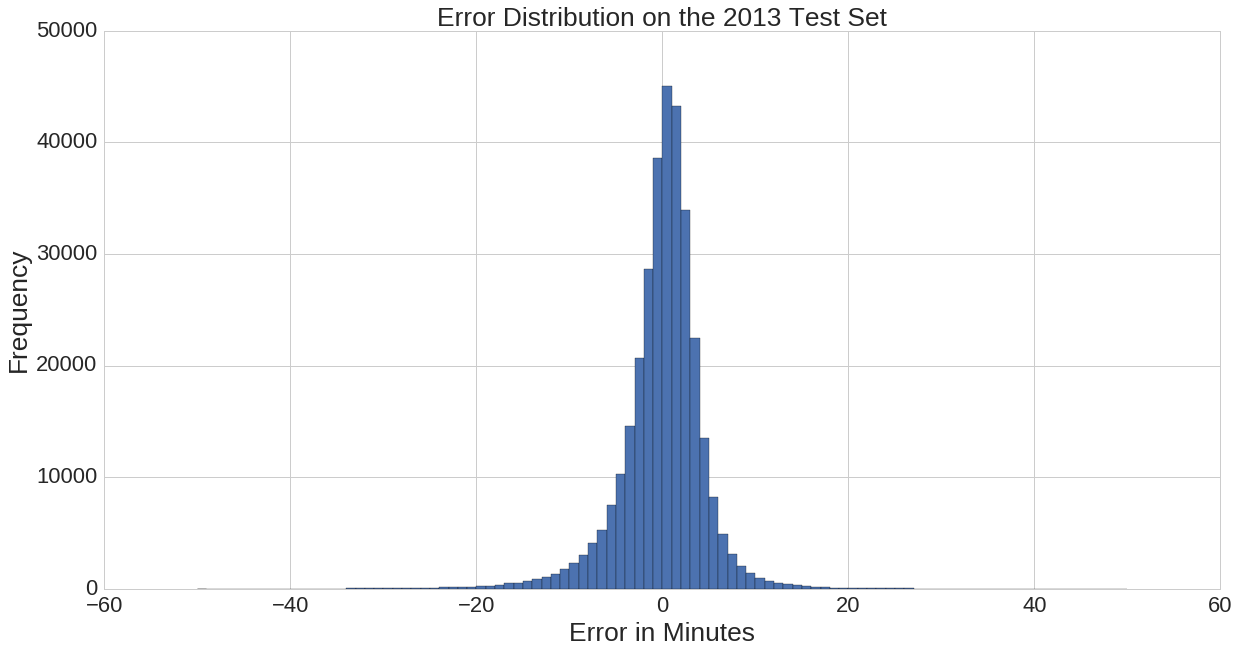

In [84]:
y_pred = regtree.predict(x_test)
np.linalg.norm(np.ceil(y_pred)-y_test)
diff = (y_pred-y_test)
# plt.figure(figsize=(12,10)) # not needed. set values globally
plt.hist(diff.values, bins=100, range=[-50, 50])
print('Perzentile(%): ', [1,5,10,15,25,50,75,90,95,99], '\n', np.percentile(diff.values, [1,5,10,15,25,50,75,90,95,99]))
print('Absolute time deviation (in 1k): ', sum(abs(diff))/1000)
plt.title('Error Distribution on the 2013 Test Set')
plt.xlabel('Error in Minutes')
plt.ylabel('Frequency')
plt.savefig('figures/simple_tree_error_d25_msp_50.eps', format='eps', dpi=1000)

In [85]:
diff.describe()

count    326634.000000
mean          0.002958
std           4.758333
min        -258.090909
25%          -1.809524
50%           0.446903
75%           2.350000
max          82.000000
Name: trip_time, dtype: float64

# Finding the leaves / predicted times

In [86]:
leaves = regtree.tree_.children_left*regtree.tree_.children_right
for idx, a in enumerate(leaves):
    if a==1:
        x=1# do nothing
    else:
        leaves[idx] = 0
print(leaves)

[0 0 0 ..., 1 1 1]


In [699]:
print(leaves[leaves==1].sum())
len(leaves[leaves==1])

67260


67260

So we have 67260 leaves.

In [88]:
len(leaves[leaves==1])/regtree.tree_.node_count

0.5000037169470484

So 50% of the nodes are leaves. A little bit cross-checking:

In [89]:
print((leaves==1).sum()+(leaves==0).sum())
print(len(leaves))

134519
134519


In [90]:
node_samples = regtree.tree_.n_node_samples
node_samples

array([2939699, 2839702, 2767340, ...,      44,      13,      11])

In [91]:
leaf_samples = np.multiply(leaves, node_samples)
stats = np.unique(leaf_samples, return_counts=True)
stats

(array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
            9,    10,    11,    12,    13,    14,    15,    16,    17,
           18,    19,    20,    21,    22,    23,    24,    25,    26,
           27,    28,    29,    30,    31,    32,    33,    34,    35,
           36,    37,    38,    39,    40,    41,    42,    43,    44,
           45,    46,    47,    48,    49,    50,    51,    52,    53,
           54,    55,    56,    57,    58,    59,    60,    61,    62,
           63,    64,    65,    66,    67,    68,    69,    70,    71,
           72,    73,    74,    75,    76,    77,    78,    79,    80,
           81,    82,    83,    84,    85,    86,    87,    88,    89,
           90,    91,    92,    93,    94,    95,    96,    97,    98,
           99,   100,   101,   102,   103,   104,   105,   106,   107,
          108,   109,   110,   111,   112,   113,   114,   115,   116,
          117,   118,   119,   120,   121,   122,   123,   124,   125,
      

## To get a feeling for the generalization of the tree: Do some leaves represent the vast amount of trips? This is what we would expect. 

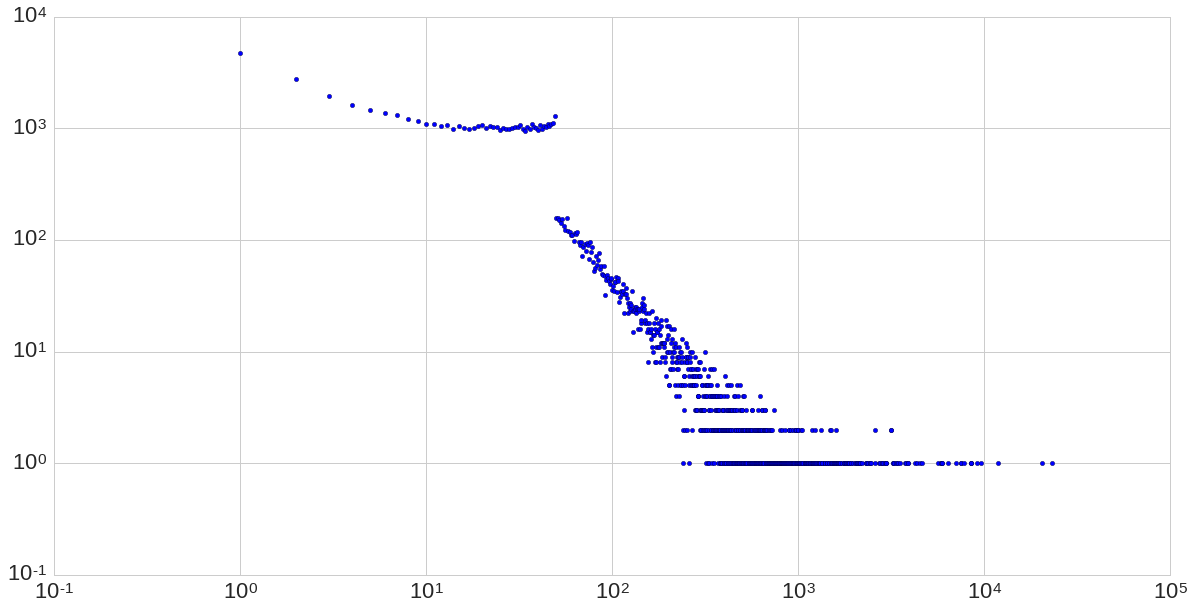

In [92]:
plt.scatter(stats[0][1:], stats[1][1:])
plt.yscale('log')
plt.xscale('log')

## The above plot looks promising, but is not very useful. Nonetheless, you can represent this in a Lorenzcurve.

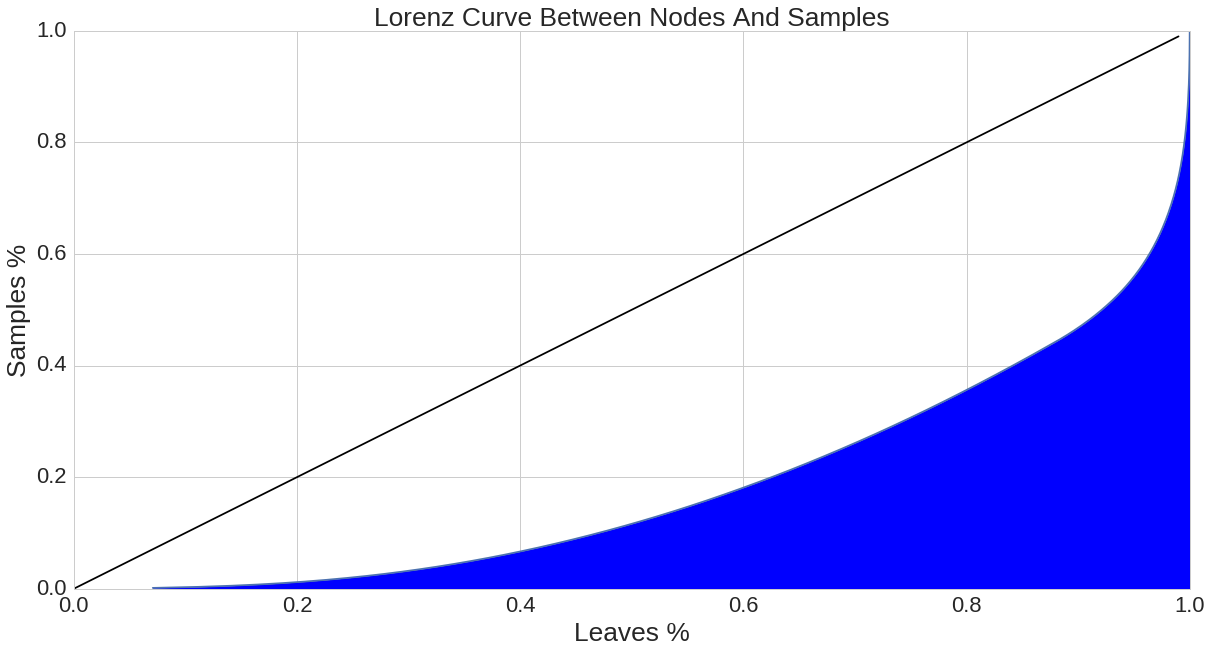

In [93]:
node_perc = np.cumsum(stats[1][1:]) # Cumulative sum of nodes
samples_perc = np.cumsum(np.multiply(stats[0][1:],stats[1][1:]))
node_perc = node_perc / node_perc[-1]
samples_perc = samples_perc / samples_perc[-1]
plt.plot(node_perc, samples_perc)
plt.plot((np.array(range(0,100,1))/100), (np.array(range(0,100,1))/100), color='black')
plt.ylim(0,1)
plt.xlim(0,1)
plt.title('Lorenz Curve Between Nodes And Samples')
plt.xlabel('Leaves %')
plt.ylabel('Samples %')
plt.fill_between(node_perc, samples_perc , color='blue', alpha='1')
plt.savefig('figures/lorenzcurve_d25_msp_50.eps', format='eps', dpi=1000)
plt.savefig('figures/lorenzcurve_d25_msp_50.png', format='png', dpi=300)

### About 5% of the leaves represent about 40% of the samples

In [651]:
len(leaf_samples)==regtree.tree_.node_count

True

We found out that all samples have been considered.

# Inspect an arbitrary leaf and extract the rule set

## We are taking a look at the leaf that represents the most samples

In [697]:
max_leaf = [np.argmax(leaf_samples), max(leaf_samples)]
print('So node no.', max_leaf[0] ,'is a leaf and has', max_leaf[1] ,'samples in it.')
print(max_leaf)

So node no. 56501 is a leaf and has 23278 samples in it.
[56501, 23278]


# Retrieve the decision path that leads to the leaf

In [680]:
# Inspired by: http://stackoverflow.com/questions/20224526/
# how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
def get_rule(tree, feature_names, leaf):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value
        samples = tree.tree_.n_node_samples
        global count
        count = 0;
        global result
        result = {};

        def recurse_up(left, right, threshold, features, node):
            global count
            global result
            count = count+1;
            #print(count)
            if node != 0:
                for i, j in enumerate(right):
                    if j == node:
                        print( 'Node:', node, 'is right of:',i, ' with ', features[i], '>', threshold[i])
                        result[count] = [features[i], False, threshold[i]]
                        return(recurse_up(left, right, threshold, features, i))
                for i, j in enumerate(left):
                    if j == node:
                        print('Node:', node,  'is left of',i,' with ', features[i], '<= ', threshold[i])
                        result[count] = [features[i], True, threshold[i]]
                        return(recurse_up(left, right, threshold, features, i))
            else :
                return(result)
        
        print('Leaf:',leaf, ', value: ', value[leaf][0][0], ', samples: ', samples[leaf])
        recurse_up(left, right, threshold, features, leaf)
        return(result)

In [681]:
branch_to_leaf=get_rule(regtree, time_regression_df.ix[:,0:6].columns,max_leaf[0])

Leaf: 56501 , value:  6.54600910731 , samples:  23278
Node: 56501 is right of: 56499  with  dropoff_longitude > -73.9948272705
Node: 56499 is right of: 56495  with  pickup_longitude > -73.9967498779
Node: 56495 is left of 56494  with  pickup_longitude <=  -73.9749832153
Node: 56494 is right of: 56478  with  dropoff_latitude > 40.7267570496
Node: 56478 is right of: 56448  with  pickup_latitude > 40.7214622498
Node: 56448 is right of: 56386  with  dropoff_longitude > -74.0030441284
Node: 56386 is right of: 56270  with  pickup_longitude > -74.0040206909
Node: 56270 is left of 56269  with  pickup_latitude <=  40.7473983765
Node: 56269 is left of 56268  with  dropoff_latitude <=  40.741607666
Node: 56268 is left of 56267  with  dropoff_longitude <=  -73.9636077881
Node: 56267 is left of 56266  with  pickup_latitude <=  40.75025177
Node: 56266 is left of 56265  with  pickup_latitude <=  40.7558288574
Node: 56265 is left of 56264  with  dropoff_latitude <=  40.7464828491
Node: 56264 is left o

In [682]:
branch_to_leaf

{1: ['dropoff_longitude', False, -73.994827270507812],
 2: ['pickup_longitude', False, -73.996749877929688],
 3: ['pickup_longitude', True, -73.974983215332031],
 4: ['dropoff_latitude', False, 40.726757049560547],
 5: ['pickup_latitude', False, 40.721462249755859],
 6: ['dropoff_longitude', False, -74.003044128417969],
 7: ['pickup_longitude', False, -74.004020690917969],
 8: ['pickup_latitude', True, 40.747398376464844],
 9: ['dropoff_latitude', True, 40.741607666015625],
 10: ['dropoff_longitude', True, -73.963607788085938],
 11: ['pickup_latitude', True, 40.750251770019531],
 12: ['pickup_latitude', True, 40.755828857421875],
 13: ['dropoff_latitude', True, 40.746482849121094],
 14: ['pickup_longitude', True, -73.962631225585938],
 15: ['pickup_latitude', True, 40.773838043212891],
 16: ['dropoff_latitude', True, 40.769866943359375],
 17: ['pickup_datetime_dayofweek', True, 4.5],
 18: ['pickup_datetime_hour', True, 18.5],
 19: ['dropoff_latitude', False, 40.724048614501953],
 20: [

### Be aware, read this branch bottom up!

Processing is nicer if the path is in a data frame.

In [683]:
splitsdf = pd.DataFrame(branch_to_leaf).transpose()
splitsdf.columns = ['features', 'leq', 'value']
splitsdf

,features,leq,value
1,dropoff_longitude,False,-73.9948
2,pickup_longitude,False,-73.9967
3,pickup_longitude,True,-73.975
4,dropoff_latitude,False,40.7268
5,pickup_latitude,False,40.7215
6,dropoff_longitude,False,-74.003
7,pickup_longitude,False,-74.004
8,pickup_latitude,True,40.7474
9,dropoff_latitude,True,40.7416
10,dropoff_longitude,True,-73.9636


Via grouping, we can extract the relevant splits that are always the ones towards the end of the branch. Earlier splits become obsolete if the feature is splitted in the same manner again downwards the tree.

In [685]:
splitstats = splitsdf.groupby(['features','leq'])
splitstats.groups

{('dropoff_latitude', False): [4, 19, 23],
 ('dropoff_latitude', True): [9, 13, 16],
 ('dropoff_longitude', False): [1, 6],
 ('dropoff_longitude', True): [10, 21, 24],
 ('pickup_datetime_dayofweek', True): [17],
 ('pickup_datetime_hour', False): [20],
 ('pickup_datetime_hour', True): [18],
 ('pickup_latitude', False): [5, 22],
 ('pickup_latitude', True): [8, 11, 12, 15],
 ('pickup_longitude', False): [2, 7],
 ('pickup_longitude', True): [3, 14, 25]}

Groupby is very helpful here. Choose always the split with the first index. "min()" is used here for demonstration purposes only.

In [698]:
splitstats.min()

value
features                  leq             
dropoff_latitude          False  40.711979
                          True   40.741608
dropoff_longitude         False -74.003044
                          True  -73.963608
pickup_datetime_dayofweek True    4.500000
pickup_datetime_hour      False   7.500000
                          True   18.500000
pickup_latitude           False  40.717377
                          True   40.747398
pickup_longitude          False -74.004021
                          True  -73.974983

One might use an own get_group method. This will throw less exceptions if the key is not valid (e.g. there is no lower range on day_of_week). This can especially happen in trees with low depth.

In [688]:
def get_group(g, key):
    if key in g.groups: return g.get_group(key)
    return pd.DataFrame(list(key).append(np.nan))

### Extract the pickup- and dropoff-area.

In [689]:
area_coords = dict()
area_coords['dropoff_upper_left'] = [splitstats.get_group(('dropoff_latitude', True)).iloc[0].value,
                  splitstats.get_group(('dropoff_longitude', False)).iloc[0].value]
area_coords['dropoff_lower_right']  = [splitstats.get_group(('dropoff_latitude',False)).iloc[0].value,
                                      splitstats.get_group(('dropoff_longitude',True)).iloc[0].value]
area_coords['pickup_upper_left']  = [splitstats.get_group(('pickup_latitude',True)).iloc[0].value, 
                  splitstats.get_group(('pickup_longitude',False)).iloc[0].value]
area_coords['pickup_lower_right']  = [splitstats.get_group(('pickup_latitude',False)).iloc[0].value,
                                     splitstats.get_group(('pickup_longitude',True)).iloc[0].value]

area_coords

{'dropoff_lower_right': [40.726757049560547, -73.963607788085938],
 'dropoff_upper_left': [40.741607666015625, -73.994827270507812],
 'pickup_lower_right': [40.721462249755859, -73.974983215332031],
 'pickup_upper_left': [40.747398376464844, -73.996749877929688]}

In [690]:
import operator 
dropoff_rect_len = list(map(operator.sub,area_coords['dropoff_upper_left'],
                                      area_coords['dropoff_lower_right']))
pickup_rect_len = list(map(operator.sub,area_coords['pickup_upper_left'],
                                      area_coords['pickup_lower_right']))
dropoff_rect_len, pickup_rect_len

([0.014850616455078125, -0.031219482421875],
 [0.025936126708984375, -0.02176666259765625])

In order to draw the rectangle, we need the side lengths of the areas.

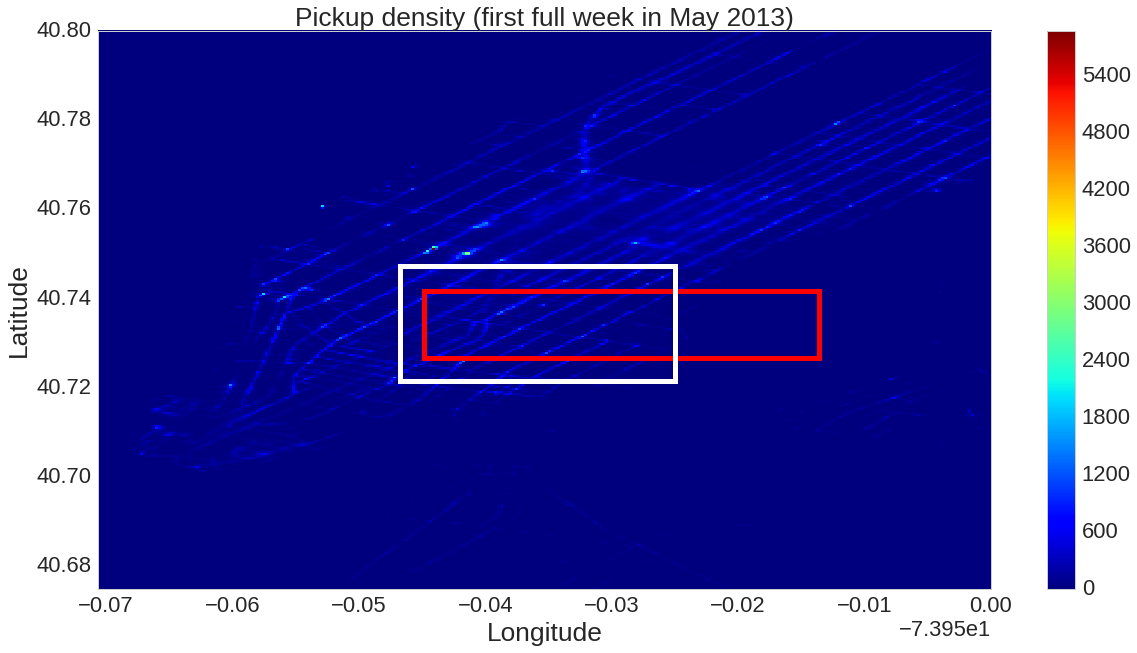

In [691]:
import matplotlib.patches as patches
x = data_in_box.pickup_longitude
y = data_in_box.pickup_latitude


fig = plt.figure(figsize=(20, 10))
# Reduce the plot to Manhattan
plt.hist2d(x, y, bins=300, range=[[min(x.values),-73.95],[40.675,40.8]])
plt.colorbar()
plt.title('Pickup density (first full week in May 2013)')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.hold(True)
ax = fig.gca()


ax.add_patch(patches.Rectangle((area_coords['dropoff_upper_left'][1], area_coords['dropoff_lower_right'][0]),
                               abs(dropoff_rect_len[1]), dropoff_rect_len[0], fill=False, edgecolor='red', linewidth=5))
ax.add_patch(patches.Rectangle((area_coords['pickup_upper_left'][1], area_coords['pickup_lower_right'][0]),
                               abs(pickup_rect_len[1]), pickup_rect_len[0], fill=False, edgecolor='white', linewidth=5))
ax.grid(False)
plt.hold(False)

### White is pickup- red is dropoff. But are this really the correct areas? Lets check it via filtering in the training set. Do we get the same amount of trips as the no. of samples in the leaf? (Time splits are hard coded in this case)

In [692]:
trips_of_leaf = x_train.loc[(x_train['dropoff_latitude'] > area_coords['dropoff_lower_right'][0]) &
                       (x_train['dropoff_longitude'] < area_coords['dropoff_lower_right'][1]) &
                       (x_train['dropoff_latitude'] < area_coords['dropoff_upper_left'][0]) & 
                       (x_train['dropoff_longitude'] > area_coords['dropoff_upper_left'][1]) & 
                       (x_train['pickup_latitude'] > area_coords['pickup_lower_right'][0]) & 
                       (x_train['pickup_longitude'] < area_coords['pickup_lower_right'][1]) &
                       (x_train['pickup_latitude'] < area_coords['pickup_upper_left'][0]) & 
                       (x_train['pickup_longitude'] > area_coords['pickup_upper_left'][1]) &
                       (x_train['pickup_datetime_dayofweek'] < 4.5) & 
                       (x_train['pickup_datetime_hour'] < 18.5) & 
                       (x_train['pickup_datetime_hour'] > 7.5)
                       ]

In [693]:
trips_of_leaf.head()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
1184741,2.0,13.0,40.742112,-73.983052,40.738077,-73.992777
2206938,4.0,12.0,40.732137,-73.984951,40.729175,-73.993996
1636835,3.0,10.0,40.730505,-73.990823,40.730505,-73.990823
1585212,3.0,9.0,40.744025,-73.981375,40.738517,-73.987492
2316670,4.0,17.0,40.742370,-73.978047,40.741061,-73.980647


In [694]:
print('Filtered trips: ', len(trips_of_leaf))
print('Trips in leaf: ', max_leaf[1])
len(trips_of_leaf) == max_leaf[1]

Filtered trips:  23282
Trips in leaf:  23278


False

## So we've found the trips that belong to this branch! The discrepancy, that might be caused by numeric instability when comparing the geo coordinates, is not that big.

# A little bit of gmaps....

In [162]:
import gmaps
import gmaps.datasets
gmaps.configure(api_key='AI****') # Fill in your API-Code here

In [650]:
trips_of_leaf_pickup_list = trips_of_leaf.iloc[:,[2,3]].as_matrix().tolist()
trips_of_leaf_dropoff_list = trips_of_leaf.iloc[:,[4,5]].as_matrix().tolist()

In [645]:
data = gmaps.datasets.load_dataset('taxi_rides')
pickups_gmap = gmaps.Map()
dropoffs_gmap = gmaps.Map()
pickups_gmap.add_layer(gmaps.Heatmap(data=trips_of_leaf_pickup_list[0:1000]))
dropoffs_gmap.add_layer(gmaps.Heatmap(data=trips_of_leaf_dropoff_list[0:1000]))

### We can see, that the intersection of the pickup- and dropoff-area is quite big. This corresponds to the predicted trip_time that is about 6.5 minutes. In this short period of time, a car cannot drive that far. It looks also quite similar to the picture above, that is based on a 2d-histogram of the pickups. We can qualitatively see, that the dropoff-area is smaller than the pickup-area.

In [695]:
pickups_gmap

In [696]:
dropoffs_gmap

### You reached the end. Thank you for your interest. - N. Haas